# Introduction to Tensorflow and Sonnet

By the end of this colab you will have trained a neural net to approximate the NXOR function based on some data. In the process you will have learnt about

* some useful tensorflow tensor operations
* building a model with *Tensorflow* and *Sonnet*
* visualizing the model you built
* getting the data into your model
* backpropagation as implemented by tensorflow
* debugging tensorflow models
* how to actually train the network.

Recall: you can use the outline on the right hand side to navigate the colab easier.

In [1]:
#@title Fetching (DM) sonnet from pip. Run this cell.
!pip install dm-sonnet

In [2]:
#@title Imports. Run this cell.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import seaborn as sns
import numpy as np
import tensorflow as tf
import sonnet as snt

from matplotlib import pyplot as plt
from google.colab import files
from scipy.stats import multivariate_normal
from IPython.display import clear_output, Image, display, HTML

sns.set_style('ticks')



/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [0]:
#@title Utility functions. Run this cell.

def get_data(num_examples):
  inputs = 2*np.random.random((num_examples, 2)) - 1
  labels = np.prod(inputs, axis=1)
  labels[labels <= 0] = -1 
  labels[labels > 0] = 1 
  return inputs, labels


def plot_nxor_data(inputs, labels, title):
  MARKER_COLORS = np.array([
      [1.0, 0.0, 0.0],  # red for -1 
      [0.0, 1.0, 0.0],  # green for +1
  ])
  class_idx = (labels + 1 / 2.0).astype(np.int)

  plt.figure()
  plt.title(title)
  plt.scatter(
      x=inputs[:, 0], y=inputs[:, 1], c=MARKER_COLORS[class_idx], alpha=0.9)
  plt.legend()
  plt.show()
  

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

  
def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph. Default to the default graph."""
    if graph_def is None:
      graph_def = tf.get_default_graph()
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:460px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:950px;height:480px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## The TensorFlow Paradigm

This section is not necessarily a fully complete introduction to tensorflow. If you are not familiar with tensorflow or don't feel comfortable with some of the content consider using a third party tutorial or the tensorflow documentation.

Instead this colab focuses on exploring the ideas underlying tensorflow and working with it, highlighting important concepts along the way.


**There are two distinct phases when it comes to working with tensorflow:**

1. Constructing the computation graph, our model,
2. Running data through this graph.

We soon see what this means.

*Note:* that with TensorFlow *Eager mode* this is not the case anymore: there the two phases happen hand in hand. Here we work with *Graph mode*, however.

### Building and displaying graphs

Let's build a simple computation graph:

In [4]:
a = tf.constant([5, 3, 1])
b = tf.constant([-1, 2, 5])
c = a + b
c

<tf.Tensor 'add:0' shape=(3,) dtype=int32>

Notice that `c` has no value associated. It is actually a (reference to a) node in the computation graph we just defined: tensorflow knows that to find the value of `c`, it needs to query the values of the nodes `a` and `b` and add them. 


**In tensorflow all computation is implemented as operations on tensors (or variables, etc), and this computation forms a graph.**

* We add tensors and operations to a graph with our Python code and libraries. 
* The tensorflow API [docs](https://www.tensorflow.org/api_docs/python/) list all available operations.
* In practice many -- if not most -- `numpy` operations have a tensorflow counterpart, though often not by that same name.

We can visualize the graph we have built so far. `show_graph()` is a utility function we defined above<sup>1</sup>; it shows the tensorboard graph representation of the graph you pass to it, right here in colab.

<small>1: The graph visualization code is from the [Jakub Arnold Blog](https://blog.jakuba.net/2017/05/30/tensorflow-visualization.html#Using-a-cloud-hosted-TensorBoard-instance-to-do-the-rendering).</small>


In [5]:
show_graph(tf.get_default_graph())

Note that in tensorflow you can have many graphs at the same time. By default, unless otherwise specified, we are building the so called "default graph" that we accessed with `tf.get_default_graph()`.

### Resetting the default graph

Recall that colab cells run in arbitrary order, maintaining python state between them. Therefore, if you run a cell that adds some tensors or operations to the graph, you will add more and more copies of them to the graph. This is probably not what you want.

**Try running the cell where we defined node `c` a few more times, then visualizing the graph.** You will see multiply copies the same nodes.

To solve this issue, tensorflow has `tf.reset_default_graph()`, which clears everything from the default graph.

In [6]:
tf.reset_default_graph()
a = tf.constant(5, name='a')
b = tf.constant(-1, name='b')
c = tf.add(a, b, name='c')
show_graph(tf.get_default_graph())

Whenever in doubt about your current graph, you can just reset it and rebuild it.

By the way, notice that in the previous code cell we labelled nodes in the graph using the `name` argument. This can often help us interpret the graph.

### Running the graph

Recall that `c` had no associated value -- we were merely informed that it is a tensor, it's shape, etc. **Tensors only have values when 'run' in a session**.

In [7]:
tf.reset_default_graph()
a = tf.constant([5, 2], name='a')
b = tf.constant([-1, 0], name='b')
c = tf.add(a, b, name='c')

with tf.Session() as session:
  print(session.run(c))

[4 2]


What really happens is that when you pass a graph node (operation, tensor, etc) to `session.run()`, tensorflow figures out what is the minimal subset of the graph to run in order to satisfy your request, and runs only that. It's difficult to appreciate this in the context of the simple graphs we had so far, but we will see a good example shortly.


You can run any node from your graph, or a combination of them.

In [8]:
with tf.Session() as session:
  print('a:', session.run(a))  # As noted above, in this case addition
                               # (required to find the value of c) is not even
                               # executed.
  print('[b, c]:', session.run([b, c]))
  print(session.run({'a': a, 'c': c}))


a: [5 2]
[b, c]: [array([-1,  0], dtype=int32), array([4, 2], dtype=int32)]
{'a': array([5, 2], dtype=int32), 'c': array([4, 2], dtype=int32)}


The data flows through the graph just once, but tensorflow runs all requested operations and tensors (along with their dependencies), returning their calculated values. We can easily illustrate how this work with tensors that get a new random value each time you run them. **Try predicting the pattern before inspecting the printed results!**

In [9]:
tf.reset_default_graph()
r = tf.random_normal(shape=(3,), mean=0.0, stddev=1.0)
x1 = r + 1  # Shifted +1
x2 = r - 1  # Shifted -1

with tf.Session() as session:
  print('x1, x2 run separately:', session.run(x1), session.run(x2))
  print('x1, x2 run together  :', session.run([x1, x2]))

x1, x2 run separately: [0.90189254 2.317982   1.1585741 ] [-0.93036133  0.3289956  -1.0331738 ]
x1, x2 run together  : [array([ 2.1460962 , -0.27647495, -0.4255407 ], dtype=float32), array([ 0.14609623, -2.276475  , -2.4255407 ], dtype=float32)]


Notice that

* when x1 and x2 were run together, the difference between correpsonding entries is always 2,
* while this is not the case when they were run separately.

This is because when run together, `r` is sampled once, and both `x1` and `x2` use this same value.

We now highlight what this means for neural network training implemented in tensorflow.

### A neural network example of tensorflow's computational model 

All computation required to train the network will be implemented as a tensorflow computation graph. In particular you will have tensor and operations like

* `train`: take a training step on some data,
* `loss`: calculate the loss on some data,
* `outputs`: give you predictions on some data,
* and so on.

Given the computation model of tensorflow:

* You will be able to `run(loss)` to calculate the loss, and **without triggering the training step computation**.
* On the other hand, running `train` will calculate the `loss` since this is what it needs to optimize.

If you `run([loss, train])`, tensorflow will take a training step and report the loss, **both based on the same data**.


As a final note, the fact that only the **minimal required subset of nodes are run** is going to be crucial when using BatchNorm: the ops that update the statistics kept in BatchNorm are not dependencies of any other ops, therefore will not get run automatically. You will experiment with this in the ConvNets and Vision Lab.

### Running a graph with state and inputs

Our examples so far have been silly in the sense that they were straightforward computation on constants, not warranting a computation graph. We now showcase a situation where the value of a tensor is not defined until it is run; this is because the value is dependent on data fed to the graph at running time.

In [10]:
tf.reset_default_graph()
a = tf.placeholder(dtype=tf.int32, shape=(), name='input')
b = tf.constant(-1, name='b')
c = tf.add(a, b, name='c')

with tf.Session() as session:
  print(session.run(c, feed_dict={a: 3}))
  print(session.run(c, feed_dict={a: 10}))

2
9


We used a `tf.placeholder`. These are tensors that have no value or computation associated to them by default, instead they simply take data so this data can be computed on by the rest of the graph.

Note that, at the same time, **any tensor may be fed with some data**.

Another strength of the computation graph approach is that some nodes may be stateful. The most common stateful node is a *variable*. **A variable is a tensor that remembers its value between run calls**. This also means **it must be initialized**. 

In the following example `a` will be a variable. We also define an `inc` operation that increments the value of `a` by 1 each time this operation is run.

In [11]:
tf.reset_default_graph()
a = tf.get_variable('counter', shape=(), dtype=tf.int64)
inc = tf.assign(a, a+1)
init_op = tf.global_variables_initializer()

with tf.Session() as session:
  session.run(init_op)     # Sets an initial value for a.
  print(session.run(a))    # By default, this is 0.
  print(session.run(a))
  session.run(inc)
  session.run(inc)
  print(session.run(a))    # We see the variable was incremented (twice).
  # If you were to print the output of inc, you see that it actually
  # returns the value of a post-increment. This is a convenience feature
  # of tf.assign().
  

0
0
2


Statefulness is highly relevant to us since the weights of our machine learning models are stored as variables and are updated by some operations in `session.run` calls during training.

### Quick Tour of Control dependencies and Race conditions

*These topics do not often come up when training simple neural networks, but they are core concepts of tensorflow and you should be familiar with them.*

With the introduction of stateful graph components we need to revisit the rule that tensorflow only executes the minimal set of operations required by a `run()` call. **Try predicting the output of the following cell.**


In [12]:
tf.reset_default_graph()
x = tf.get_variable("x", shape=(), initializer=tf.zeros_initializer())
assign_x = tf.assign(x, 10.0)
z = x + 1.0

init = tf.global_variables_initializer()
with tf.Session() as session:
  session.run(init)
  print(session.run(z))

1.0


From tensorflow's perspective,

* There is a variable `x`, which starts with value 0,
* `z` is always `x+1`,
* with `assign_x` you can set the value of `x` to 10.

So if you simply ask for the value of `z`, tensorflow evaluates the minimal subset of the graph it needs and reports that `z = 0 + 1`.  This is reflected in the graph as well.

In [13]:
show_graph()

If you want `x` incremented by 10 before using it to calculate `z`, you need to tell tensorflow.  You can do so by specifying `assign_x` as a (control_)dependency of z.

In [14]:
tf.reset_default_graph()
x = tf.get_variable("x", shape=(), initializer=tf.zeros_initializer())
assign_x = tf.assign(x, 10.0)
with tf.control_dependencies([assign_x]):
  z = x + 1.0

init = tf.global_variables_initializer()
with tf.Session() as session:
  session.run(init)
  print(session.run(z))

11.0


To be precise, `tf.control_dependencies` ensures all operations / tensors passed to it are run before running the the operations defined inside its body.

The other rule to keep in mind is that **Tensorflow is inherently parallel.** If there are computation subgraphs that do not depend on each other, they can -- and likely will be -- evaluated in parallel. We use the same generic example to illustrate this.

In [15]:
tf.reset_default_graph()
x = tf.get_variable("x", shape=(), initializer=tf.zeros_initializer())
assign_x10 = tf.assign(x, 10.0)
assign_x5 = tf.assign(x, 5.0)
z = x + 1.0

init = tf.global_variables_initializer()
with tf.Session() as session:
  session.run(init)
  for _ in range(10):
    _, _, z_val = session.run([assign_x10, assign_x5, z])
    print(z_val)

6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0


We can see that `z` can take various values: its value will depend on what order the different operations get run -- which we don't control. (If you do not see different values, re-run the cell until you do. If it doesn't help, this property has probably changed in some recent update of TensorFlow.)

The lesson is that **if you care about the order of otherwise independent operations, you must be explicit about this**. 

### Exercise: "Interactive Tensorflow Summing Machine"

Write a tensorflow graph which keeps a running sum of the integers passed to it through a `feed_dict`. To make sure it works feed the machine a few numbers, printing the cumulative sum after each step.

In [0]:
#@title Your Code

In [17]:
#@title Solution

tf.reset_default_graph()
cumulative_sum = tf.get_variable('sum', shape=(), dtype=tf.int64)
to_add = tf.placeholder(dtype=tf.int64, shape=(), name='input')
add = tf.assign(cumulative_sum, cumulative_sum + to_add)
init_op = tf.global_variables_initializer()

with tf.Session() as session:
  session.run(init_op)  # Sets an initial value for a.
  for i in range(1, 6):
    print('cumulative sum={}; adding {}.'.format(session.run(cumulative_sum), i))
    session.run(add, feed_dict={to_add: i})
  

cumulative sum=0; adding 1.
cumulative sum=1; adding 2.
cumulative sum=3; adding 3.
cumulative sum=6; adding 4.
cumulative sum=10; adding 5.


## A word (section) on tensorflow tensor shapes

Tensors in Tensorflow have **static and dynamic shape**.

* Static shape information is known or can be deduced at graph construction time,
* Dynamic shape information is only available when data is available.

**Static shape may be and is often only partially defined**. For example, we may know that our model expect a batch of examples, each of shape `2 x 2`, but not how large these batches are. This will allow us to feed the computation graph with batches of any size. Once data is fed the tensors will have a known **dynamic shape**.

In [18]:
tf.reset_default_graph()
inputs = tf.placeholder(dtype=tf.int32, shape=(None, 2, 2), name='input')
print('static shape:', inputs.shape)


static shape: (?, 2, 2)


We pass `None` for axes that we do not know the static length of when specifying a shape. When a tensor or its shape is printed, this is denoted by a question mark, `?`, as seen above.


**Bug-alert:**  Be careful not to confuse passing `(None)` vs `(None,)` as a desired shape. The next cell illustrates the consequences:

In [19]:
inputs_1 = tf.placeholder(dtype=tf.int32, shape=(None), name='input')
inputs_2 = tf.placeholder(dtype=tf.int32, shape=(None,), name='input')
print(inputs_1.shape)   # Shape that we know nothing about, not even rank.
print(inputs_2.shape)   # Tensorflow will assert that the tensor is of rank 1,
                        # albeit with unknwon length.

<unknown>
(?,)


The static shape information is used to

* verify operations make sense (think matrix multiplication),
* infer the static shape of tensors defined through operations (so they can also be checked) .

**Example**

1. We take `batch (?) x 2 x 2`-shaped tensors, flatten each example in the batch to be a vector of length `4`. Tensorflow will infer the shape of the flattened tensor automatically.
2. Then we multiply the now `? x 4`-shaped tensor with a vector. Tensorflow will only allow this to happen if the vector is of length 4, as otherwise the operation makes no sense.

(In practice the `tf.matmul` operation we use does not accept vectors, so we will use a `4 x 1` matrix instead.)

In [20]:
tf.reset_default_graph()

inputs = tf.placeholder(dtype=tf.int32, shape=(None, 2, 2), name='input')
flat_inputs = tf.contrib.layers.flatten(inputs)
print('flat_inputs static shape', flat_inputs.shape)

result = tf.matmul(flat_inputs, tf.constant([[0], [1], [2], [3]], name='ok'))
print('result static shape', result.shape)

# Uncomment and run to see
#
# ValueError: Dimensions must be equal, but are 4 and 3 for 'MatMul_4'
# (op: 'MatMul') with input shapes: [?,4], [3,1].
#
# tf.matmul(flat_inputs, tf.constant([[0], [1], [2]], name='shape_mismatch'))


flat_inputs static shape (?, 4)
result static shape (?, 1)


It happens sometimes (e.g. for custom operations) that tensorflow is not be able to infer the static shape of the resulting tensor.  f you know the expected shape, you can explicitly set it using `tensor.set_shape()`. This will allow tensorflow to infer and check later shapes.

Finally, let us try working with the dynamic shape of a tensor.

In [21]:
print('dynamic shape:', tf.shape(inputs))

dynamic shape: Tensor("Shape:0", shape=(3,), dtype=int32)


The **dynamic shape itself is a tensor** and may (only) be evaluated or computed with once the graph is run in a session.

In [22]:
shape = tf.shape(inputs)
num_total_elements = tf.reduce_prod(shape)

with tf.Session() as session:
  print(session.run([shape, num_total_elements], feed_dict={
      inputs: np.array(np.random.random((3, 2, 2)))
  }))


[array([3, 2, 2], dtype=int32), 12]


### Broadcasting

Tensorflow automatically broadcasts operations, similarly to `numpy`. We covered broadcasting in detail in the `numpy` colab. Here we include three common examples.

In [23]:
tf.reset_default_graph()

a = tf.constant([[1, 2, 3], [4, 5, 6]], name='a')
c = a - 1   # `1` is first turned into a constant,
            # then broadcast across the full tensor

with tf.Session() as session:
    print(session.run(c))

[[0 1 2]
 [3 4 5]]


In [24]:
tf.reset_default_graph()

a = tf.constant([[1, 2, 3], [4, 5, 6]], name='a')
b = tf.constant([1000, 100, 10], name='b')
c = a + b
# a: 2 x 3
# b:     3
# --> b is copied over across the first axis to calculate c.

with tf.Session() as session:
    print(session.run(c))

[[1001  102   13]
 [1004  105   16]]


In [0]:
tf.reset_default_graph()

a = tf.constant([[1, 2, 3], [4, 5, 6]], name='a')
b = tf.constant([100, 10], name='b')
# a: 2 x 3
# b:     2
# --> a and b are not compatible;
# a + b    # Raises an error.

# Uncomment lines below to see the error
#c = a + b
#with tf.Session() as session:
#    print(session.run(c))

In [26]:
# Instead, b can be defined as [[100], [10]] so that
# a: 2 x 3
# b: 2 x 1
# --> b is copied across the last axis.

tf.reset_default_graph()

a = tf.constant([[1, 2, 3], [4, 5, 6]], name='a')
b = tf.constant([[100], [10]], name='b')

c = a + b

with tf.Session() as session:
   print(session.run(c))

[[101 102 103]
 [ 14  15  16]]


**As a general rule of thumb**

* use broadcasting in the simple cases
* prefer explicit broadcasting in complex situations.

This will result in code that is **easier to read** and has **fewer bugs**.

## Building a simple network with Sonnet

Instead of building our neural networks in plain Tensorflow, we use the [sonnet](https://github.com/deepmind/sonnet) library.

**Sonnet uses an object-oriented approach, similar to Torch/NN.**

* This allows modules to be created, which define the forward pass of some computation. 
* Modules are ‘called’ with some input Tensors, which adds ops to the Graph and returns output Tensors.

We call this a **configure-then-connect principle**, which allows for easy reuse of complex modules.


In [0]:
tf.reset_default_graph()  # You can always clear the current graph and
                          # add exactly what you need to it.

Start by creating a Linear module (dense layer).

In [28]:
linear = snt.Linear(output_size=5)
linear

Our input will be batches of 2-long vectors, and we will feed that data to the graph using `feed_dict`s.

In [0]:
inputs_placeholder = tf.placeholder(tf.float32, shape=(None, 2), name='inputs')

As in tensorflow, we "call" the module on the tensor that we want it to compute on. This yields a tensor, the output of the calculation.

In [0]:
pre_activations = linear(inputs_placeholder)

To complete our model, we apply a ReLU non-linearity and add a final linear layer with just 1 output.

In [31]:
activations = tf.nn.relu(pre_activations)
outputs = snt.Linear(output_size=1)(activations)
outputs

<tf.Tensor 'linear_1/add:0' shape=(?, 1) dtype=float32>

We drop the final singleton axis so that `outputs` becomes a vector.

In [32]:
outputs = tf.squeeze(outputs, axis=-1)
outputs

<tf.Tensor 'Squeeze:0' shape=(?,) dtype=float32>

Let's see the graph we built.

In [33]:
show_graph()   # With no arguments show_graph() shows the default graph.

You can explore the exact set of tensorflow operations that were created the sonnet code by expanding colored boxes. **We can verify that each linear layer implements $WX+b$ for $X$ inputs and $W$ weights and $b$ bias with basic tensorflow operations**.

Let's pass some data through our model. We will use the data generating function we wrote in the numpy colab. (It is redefined at the top of this colab).

In [0]:
init_op = tf.global_variables_initializer()

In [35]:
inputs_np, unused_labels_np = get_data(num_examples=8)

with tf.Session() as session:
  session.run(init_op)  # Initializes the weights in the network.
  outputs_np = session.run(outputs, feed_dict={
      inputs_placeholder: inputs_np,
  })

outputs_np

array([-0.20226629, -0.10785677, -0.3542385 , -0.10319658, -0.31243905,
       -0.08991615, -0.13809332,  0.02503894], dtype=float32)

You can rerun the above cell to see the output on new and new batches. The one thing that now remains is...



## Training a tensorflow model

This is the same with or without sonnet. 

We will start by

1. Making the correct labels available to the graph,
2. Using these to define and calculate the loss on the output of the network.

In [0]:
labels_placeholder = tf.placeholder(tf.float32, shape=(None,), name='labels')


Here we will simply regress onto the labels with the squared loss. (It would be better to calculate a cross entropy.)

In [37]:
with tf.name_scope('element_wise_loss'):
  loss = tf.square(labels_placeholder - outputs)
loss

<tf.Tensor 'element_wise_loss/Square:0' shape=(?,) dtype=float32>

The loss tensor now calculates the loss per example. We want one scalar to optimize:

In [38]:
loss = tf.reduce_mean(loss, name='batch_mean_loss')
loss

<tf.Tensor 'batch_mean_loss:0' shape=() dtype=float32>

We can verify on the graph that everything is as expected. The `name_scope` and `name` instructions make the graph easier to interpret.

In [39]:
show_graph()

We need to tell the computation graph that we want to minimize this loss.

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(loss)

**It is worth noting here the effect of this call on the graph.**

In [41]:
show_graph()

The minimization call added

* gradient calculation operations
* operations that update the weights based on these gradients.

In fact, **we could have built the graph corresponding to `minimize()` manually** by

* calculating the gradients of the loss with respect to the weights with the `tf.gradients(loss, [list of weights])` operation,
* potentially scaling these gradients and adding them to the existing weights.


By running the returned `train_op`, we take one gradient step, fitting the data just a bit better. Let's do this! But first some setup.

No handles with labels found to put in legend.


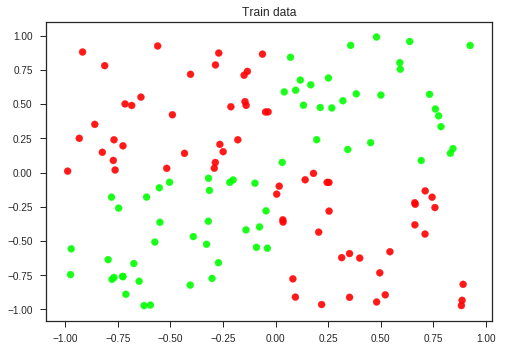

Mean label on train data: 0.0


In [42]:
# Get some training data, and plot it. This is based on earlier exercises.
inputs_np, true_labels_np = get_data(num_examples=128)
plot_nxor_data(inputs_np, true_labels_np, title='Train data')

# Show some statistics that can help with debugging
print('Mean label on train data:', np.mean(true_labels_np))


In [0]:
init_op = tf.global_variables_initializer()

**The final training script.**  

This cell contains all training and some reporting code. For now you can just run it, but for the next exercise you will have to understand it.

*Note that sometimes we can get a bad weight initialization, but in a few runs you can easily get below 5% error.*

Losses:
  1.4765615
  0.5479122
  0.53353727
  0.53222066
  0.5321189
  0.53204876
  0.5320318
  0.53202426
  0.5320175
  0.5320116


No handles with labels found to put in legend.



Prediction error: 0.1796875


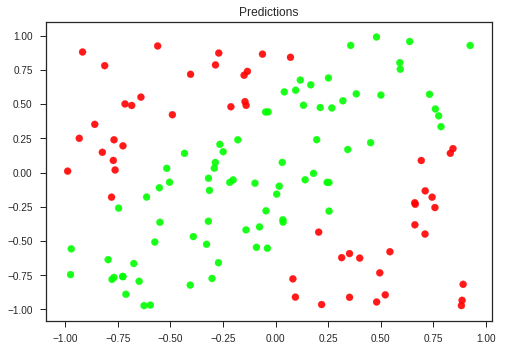

In [44]:
RECORD_PERIOD = int(1e3)

training_steps = 10000   #@param {'type': 'integer'}

print('Losses:')
with tf.Session() as session:
  session.run(init_op)  # Initializes the weights in the network.

  for i in range(training_steps):
    _, loss_np = session.run(
        [train_op, loss],
        feed_dict={
            inputs_placeholder: inputs_np,
            labels_placeholder: true_labels_np,
    })
    if (i % RECORD_PERIOD) == 0:
      print(' ', loss_np)
      if loss_np < 0.01:
        print()
        print('Loss hit threshold after {} steps, stopping.'.format(i))
        break
  
  print()
  # The model is ready to be evaluated. Fetch the predicted outputs.
  predictions_np = session.run(outputs,
      feed_dict={
          inputs_placeholder: inputs_np,
  })
  # Actual label predictions given as {-1, +1}.
  predictions_np[predictions_np <= 0] = -1
  predictions_np[predictions_np > 0] = 1
  # Prediction errors and plotting.
  num_correct = np.count_nonzero(np.isclose(predictions_np, true_labels_np))
  num_examples = true_labels_np.shape[0]
  print('Prediction error:', (num_examples-num_correct)/num_examples)
  plot_nxor_data(inputs_np, predictions_np, title='Predictions')
  

Notice that the prediction error calculation was inside the `with tf.Session()` context manager. This because **the graph state (including weights) is only maintained on a per session basis**. It is possible to save (and load) graphs, including their weights, with a [`tf.train.Saver`](https://www.tensorflow.org/api_docs/python/tf/train/Saver).

## Exercise:  Evaluate the trained model

We have seen how to train the model -- that is -- we saw that the model can fit the training set well. But we are actually  interested in generalizing to new examples from the same data distribution.

1. Define a training and a test dataset using our data generation function.
2. Fit the training data using the model we defined above.
3. Instead of reporting the prediction error only on the training set, also report it on the test set.
4. Plot the predictions on the test set using the pre-defined plotting function.

For simplicity, the full model building code is included in the cell below:

In [0]:
tf.reset_default_graph()

# Inputs.
inputs_placeholder = tf.placeholder(tf.float32, shape=(None, 2), name='inputs')
labels_placeholder = tf.placeholder(tf.float32, shape=(None,), name='labels')

# All network and loss definition.
activations = tf.nn.relu(
    snt.Linear(output_size=5)(inputs_placeholder))
outputs = tf.squeeze(
    snt.Linear(output_size=1)(activations), axis=-1)
loss = tf.reduce_mean(
    tf.squared_difference(labels_placeholder, outputs))

# Optimizer and initializer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03)
train_op = optimizer.minimize(loss)
init_op = tf.global_variables_initializer()

In [0]:
#@title Your Code

Losses:
  1.1336524
  0.28121048
  0.23818028
  0.22827783
  0.22418705
  0.22167976
  0.22007261
  0.21804881
  0.21632989
  0.21486689
  0.21356952
  0.21236472
  0.21124062
  0.21020739
  0.20926717
  0.20804979
  0.206828
  0.20571767
  0.20479813
  0.20397347


No handles with labels found to put in legend.



Train error: 0.0078125
Test error: 0.0546875


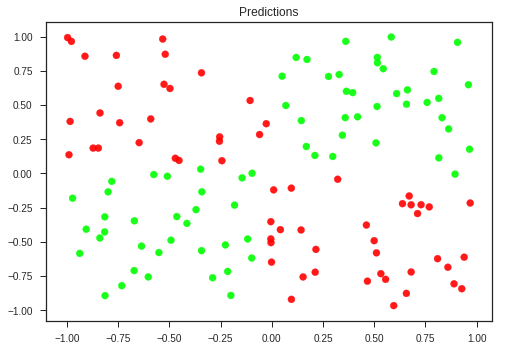

In [46]:
#@title Solution

# The solution is very similar to the previous training script, except care
# needs to be taken to have a separate train and test set.

train_inputs_np, train_labels_np = get_data(num_examples=256)
test_inputs_np, test_labels_np = get_data(num_examples=128)


TRAINING_STEPS = int(2e4)
RECORD_PERIOD = int(1e3)


def _get_predictions(inputs):
  predictions_np = session.run(outputs,
      feed_dict={
          inputs_placeholder: inputs,
  })
  # Actual label predictions given as {-1, +1}.
  predictions_np[predictions_np <= 0] = -1
  predictions_np[predictions_np > 0] = 1
  return predictions_np


def _get_error(predictions, true_labels):
  num_correct = np.count_nonzero(np.isclose(predictions, true_labels))
  num_examples = true_labels.shape[0]
  return (num_examples-num_correct) / num_examples


print('Losses:')
with tf.Session() as session:
  session.run(init_op)  # Initializes the weights in the network.

  for i in range(TRAINING_STEPS):
    _, loss_np = session.run(
        [train_op, loss],
        feed_dict={
            inputs_placeholder: train_inputs_np,
            labels_placeholder: train_labels_np,
    })
    if (i % RECORD_PERIOD) == 0:
      print(' ', loss_np)
      if loss_np < 0.01:
        print()
        print('Loss hit threshold after {} steps, stopping.'.format(i))
        break
  
  print()
  # The model is ready to be evaluated.
  train_predictions = _get_predictions(train_inputs_np)
  train_error = _get_error(train_predictions, train_labels_np)
  
  test_predictions = _get_predictions(test_inputs_np)
  test_error = _get_error(test_predictions, test_labels_np)
  
  print('Train error:', train_error)
  print('Test error:', test_error)
  plot_nxor_data(test_inputs_np, test_predictions, title='Predictions')
  


## Datasets

So far we used a `feed_dict`s to pass data to the computation graph. Another, often more efficient solution is to have nodes in the graph read, maninpulate, and make data available.

Tensorflow has a dedicated `tf.data` module.  Tensorflow's [Importing Data Guide](https://www.tensorflow.org/guide/datasets) guide is a great resource for learning about it. **Read this guide up to and including the "Reading input data > Consuming NumPy arrays"** section.





### Exercise: define a tensorflow dataset

1. Use the `get_data` function from before to generate a training dataset of 1000 examples and a test dataset of 500 examples.
2. Using `from_tensor_slices()`, define a training and a test `tf.data.Dataset`.
3. Ensure that the train data is (a) fully shuffled (b) can be iterated infinitely (c) is batched with a batch size of 64.
4. We do not shuffle the test data and we only want to iterate it once. We still batch it up so that the amount of data we compute on is limited.

**Write a function called `get_tf_dataset()` that returns a (`train_dataset, test_dataset`)-tuple according to these instructions.** Print the returned datasets in order to verify they are correctly defined.

In [0]:
tf.reset_default_graph()

In [0]:
#@title Your Code

In [48]:
#@title Solution

BATCH_SIZE = 64

train_data_np = get_data(1000)
test_data_np = get_data(500)

def get_tf_dataset():
  train_dataset = tf.data.Dataset.from_tensor_slices(train_data_np)
  train_dataset = train_dataset.shuffle(1000).repeat().batch(BATCH_SIZE)

  test_dataset = tf.data.Dataset.from_tensor_slices(test_data_np)
  test_dataset = test_dataset.batch(BATCH_SIZE)
  
  return train_dataset, test_dataset

print(get_tf_dataset())

(<BatchDataset shapes: ((?, 2), (?,)), types: (tf.float64, tf.float64)>, <BatchDataset shapes: ((?, 2), (?,)), types: (tf.float64, tf.float64)>)


We need to access the data as tensors. We can do so by asking for an iterator over the dataset. We use the simplest iterator, which simply iterates over the dataset:

In [0]:
train_dataset, test_dataset = get_tf_dataset()

In [50]:
train_data_iter = train_dataset.make_one_shot_iterator()
(train_inputs, train_labels) = train_data_iter.get_next()
train_inputs, train_labels

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


(<tf.Tensor 'IteratorGetNext:0' shape=(?, 2) dtype=float64>,
 <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=float64>)

In [51]:
test_data = test_dataset.make_one_shot_iterator().get_next()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Now we can use `train_inputs` and `train_labels` like any other tensor. Each time we use them in a `session.run()` the tensor will hold a new batch.

In [52]:
def _print_some(np_array, descr):
  print(descr + ':')
  print('  shape: {}'.format(np_array.shape))
  print('  first examples in batch: {}'.format(np_array[:4]))


with tf.Session() as session:
  # Train data.
  for _ in range(2):
    train_inputs_np, train_labels_np = session.run([train_inputs, train_labels])
    _print_some(train_inputs_np, 'train_inputs')
    _print_some(train_labels_np, 'train_labels')
    print()
  
  # Test data.
  test_inputs_np, test_labels_np = session.run(test_data)
  _print_some(test_inputs_np, 'test_inputs')
  _print_some(test_labels_np, 'test_labels')
  
  

train_inputs:
  shape: (64, 2)
  first examples in batch: [[-0.77970678  0.83275118]
 [-0.25316549 -0.08453884]
 [ 0.75753673 -0.50019721]
 [-0.1490616  -0.48406708]]
train_labels:
  shape: (64,)
  first examples in batch: [-1.  1. -1.  1.]

train_inputs:
  shape: (64, 2)
  first examples in batch: [[ 0.0075258   0.78759492]
 [-0.1726779   0.95539586]
 [ 0.26766155  0.23550177]
 [-0.07351927  0.05023691]]
train_labels:
  shape: (64,)
  first examples in batch: [ 1. -1.  1. -1.]

test_inputs:
  shape: (64, 2)
  first examples in batch: [[ 0.06985234  0.10455586]
 [-0.20353231 -0.65704676]
 [-0.04796583 -0.50909849]
 [ 0.70678073 -0.37274402]]
test_labels:
  shape: (64,)
  first examples in batch: [ 1.  1.  1. -1.]


We defined the test dataset to supply data for exacly one full iteration of the test dataset. We can fetch data until tensorflow lets us know there is no more data.

In [53]:
with tf.Session() as session:
  counter = 0
  while True:
    try:
      test_inputs_np, test_labels_np = session.run(test_data)
      counter += 1
    except tf.errors.OutOfRangeError:
      break
  print('Counted {} batches of test examples.'.format(counter))
  
  

Counted 8 batches of test examples.


The `make_one_shot_iterator()` function returns an iterator that, when exhausted, cannot be restarted. 

There are many utility functions in the `tf.data` both for reading in and manipulating data; chances are, whatever you would like to do it is already available there.

### Queues

In earlier versions of tensorflow datasets had to be manipulated with so called [Queues](https://www.tensorflow.org/api_guides/python/threading_and_queues). They allowed data loading and preprocessing to be asynchronous, making the input pipeline faster. Their use for input pipelines is now deprecated, if you are interested in increasing the performance of your input pipeline read the [official guide on this topic](https://www.tensorflow.org/performance/datasets_performance).

Queues are still used for pushing data between different threads, potentially on different machines, but we will not cover them in this lab.


## The Power of Sonnet

The Sonnet library has two key selling points:

* Complex networks are easily reused.
* Variable sharing is handled transparently by automatically reusing variables on subsequent calls to the same module. 

We will now see these features in action.


We start by defining a sonnet module corresponding to the classifier we have been working with. The section on [defining your own submodules](https://deepmind.github.io/sonnet/#defining-your-own-modules) in the sonnet documentation is both helpful and precise. The key points are:

* Inherit from snt.AbstractModule
* Call superclass constructor
* Implement the `_build()` method

The `_build()` method is meant to construct all computation graph corresponding to this module. It takes as argument the inputs to the module, and returns the outputs.



In [0]:
class MySimpleModule(snt.AbstractModule):

  def __init__(self, num_hidden, nonlinearity=tf.nn.relu,
               name="my_simple_module"):
    super(MySimpleModule, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._nonlinearity = nonlinearity
   
  def _build(self, inputs):
    # Inputs has shape batch_size x ?.
    pre_activations = snt.Linear(output_size=self._num_hidden)(inputs)
    activations = self._nonlinearity(pre_activations)
    outputs = snt.Linear(output_size=1)(activations)
    return tf.squeeze(outputs, axis=-1)  # Shape: [batch_size].


Aside: since this module is simply a sequence of other modules and tensorflow ops (e.g. the non-linearity), the module could have been made using the `snt.Sequential()` wrapper.

We can make a particular instance of the module we defined like so:

In [0]:
tf.reset_default_graph()
model = MySimpleModule(num_hidden=5)

In [56]:
model

No graph has actually been created so far, since only the constructor of the class ran. Let's connect this module to the training data.

*Note that while it is encouraged to only create graph in the `_build()` method, some sonnet modules may already do so in their constructor.*

In [0]:
train_dataset, test_dataset = get_tf_dataset()
train_inputs, train_labels = train_dataset.make_one_shot_iterator().get_next()
train_ouputs = model(train_inputs)

The connection triggered the `_build()` function and we can see the graph corresponding to the model is built.

In [0]:
# show_graph()

The beauty of sonnet is that we can **connect the same `model` instance to the test data tensor and it will automatically share variables**.

In [59]:
test_inputs, test_labels = test_dataset.make_one_shot_iterator().get_next()
test_outputs = model(test_inputs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Of course creating another instance will not share variables. Can you tell, based on the graph (not considering the names) which modules share weights?

In [0]:
unshared_test_outputs = MySimpleModule(num_hidden=5, name='unshared_simple_module')(test_inputs)
# show_graph()

The fact that `train_outputs` and `test_outputs` use shared variables means that training based on `train_outputs` will improve the quality of `test_ouputs` as well. We show this next.

We base the training script here based on our previous one. Some modifications are required:

* The references to the dataset must be updated. We do not use `feed_dicts`, but we must take care to run `test_outputs` or `train_outputs`.
* In order to get the true (test) labels, we need to run the `test_labels` tensor.
* We need to iterate over the full test dataset.

Another change is that now each training step uses a different batch of data, while our earlier version used the full (smaller) dataset.


In [0]:
# CHANGED HERE:
loss = tf.reduce_mean(tf.squared_difference(train_labels, train_ouputs))

# Optimizer and initializer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03)
train_op = optimizer.minimize(loss)
init_op = tf.global_variables_initializer()

In [62]:
TRAINING_STEPS = int(2e4)
RECORD_PERIOD = int(1e3)

def _num_correct(predictions_np, true_labels_np):
  # Actual label predictions given as {-1, +1}.
  predictions_np[predictions_np <= 0] = -1
  predictions_np[predictions_np > 0] = 1
  # Count correct predictions.
  return np.count_nonzero(np.isclose(predictions_np, true_labels_np))

  
print('Losses:')
with tf.Session() as session:
  session.run(init_op)  # Initializes the weights in the network.

  for i in range(TRAINING_STEPS):
    _, loss_np = session.run([train_op, loss])  # CHANGED HERE.
    if (i % RECORD_PERIOD) == 0:
      print(' ', loss_np)
  
  print()
  # The model is ready to be evaluated. Fetch the predicted outputs.
  num_correct = 0
  num_elements = 0
  while True:
    try:
      # CHANGES HERE.
      predictions_np, true_labels_np = session.run([test_outputs, test_labels])
      num_elements += predictions_np.shape[0]
      num_correct += _num_correct(predictions_np, true_labels_np)
    except tf.errors.OutOfRangeError:
      break
  print('The prediction error on the test set:',
        (num_elements - num_correct) / num_elements)
  

Losses:
  1.3201479951168045
  0.4605388847178207
  0.3406420333238114
  0.31004910843159367
  0.40647830317154443
  0.29042885743586655
  0.325219506815832
  0.3668264536020975
  0.3669024601824853
  0.4334609395723311
  0.3365587091005339
  0.3172966199892461
  0.402922975796816
  0.2899498820843459
  0.324035611942856
  0.4172252047407158
  0.2624667300127498
  0.3457677096247219
  0.36141076226431923
  0.3227045729145533

The prediction error on the test set: 0.072


We will see another convenient feature of Sonnet when working with generative models in the VAE and GAN lab.

## Debugging Tensorflow

Debugging tensorflow code and models can be challenging when compared to debugging 1) simple python code or even 2) other machine learning code. This is due to the separate building and running phases* of tensorflow:

* You cannot simply just stop the computation midway in a `run()` call and inspect what is going on. **
* If an error is only revealed in a `session.run()` call, Tensorflow may often be unable to point you to the python code that generated the offending operation.
* Race conditions may occur. These can be hard to detect because the race condition may only occur very very infrequently.

In this section we list some practical advice to debugging tensorflow.

<small>*&ast;Tensorflow's Eager mode removes this separation, making debugging simpler.</small><br />
<small>*&ast;*&ast;There is a [tensorflow debugger](https://www.tensorflow.org/programmers_guide/debugger) that tries to address this problem.*</small>



* **Check your shapes**. It is possible that something is not of the shape you expect, but due to broadcasting the graph still computes something -- but not what you want.
* **Check the graph with tensorboard**. Does it do what you wanted it to?
* **Print and/or assert values of tensors**. While you cannot stop your graph mid-computation, you can print the values going through them. Unfortunately this [does not currently work](https://www.tensorflow.org/api_docs/python/tf/Print) in notebooks.

## Not covered: Control Flow

In tensorflow you can define logical operations such as conditionals, loops, etc. In fact, Tensorflow is Turing-complete. We do not cover them as these operations are not usually required for training neural nets, and it is better to avoid them unless really needed due their added compexity.
